In [3]:
!wget https://github.com/CSSEGISandData/COVID-19/archive/master.zip -O data_covid19.zip
!rm -rf COVID-19-master
!unzip data_covid19
!rm data_covid19.zip

ved_data/archived_daily_case_updates/01-26-2020_1100.csv  
  inflating: COVID-19-master/archived_data/archived_daily_case_updates/01-26-2020_2300.csv  
  inflating: COVID-19-master/archived_data/archived_daily_case_updates/01-27-2020_0900.csv  
  inflating: COVID-19-master/archived_data/archived_daily_case_updates/01-27-2020_1900.csv  
  inflating: COVID-19-master/archived_data/archived_daily_case_updates/01-27-2020_2030.csv  
  inflating: COVID-19-master/archived_data/archived_daily_case_updates/01-28-2020_1300.csv  
  inflating: COVID-19-master/archived_data/archived_daily_case_updates/01-28-2020_1800.csv  
  inflating: COVID-19-master/archived_data/archived_daily_case_updates/01-28-2020_2300.csv  
  inflating: COVID-19-master/archived_data/archived_daily_case_updates/01-29-2020_1330.csv  
  inflating: COVID-19-master/archived_data/archived_daily_case_updates/01-29-2020_1430.csv  
  inflating: COVID-19-master/archived_data/archived_daily_case_updates/01-29-2020_2100.csv  
  inflating

In [4]:
!pip install geopandas

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import pandas as pd
import numpy as np
import os
from skimage import io

import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
root_path = 'COVID-19-master/csse_covid_19_data/csse_covid_19_daily_reports/'

recent = sorted(os.listdir(root_path))[-2]
path = os.path.join(root_path, recent)
df = pd.read_csv(path)
print(df.shape)

df = df.rename({"Country_Region":"Country/Region"}, axis="columns")
df = df.rename({"Long_":"Longitude"}, axis="columns")
df = df.rename({"Lat":"Latitude"}, axis="columns")
df = df.drop(columns=['FIPS', 'Admin2'])

display(df)
country = df['Country/Region'].to_numpy()
print(np.unique(country))

(3430, 12)


,Province_State,Country/Region,Last_Update,Latitude,Longitude,Confirmed,Deaths,Recovered,Active,Combined_Key
0,South Carolina,US,2020-03-28 23:05:37,34.223334,-82.461707,3,0,0,0,"Abbeville, South Carolina, US"
1,Louisiana,US,2020-03-28 23:05:37,30.295065,-92.414197,9,1,0,0,"Acadia, Louisiana, US"
2,Virginia,US,2020-03-28 23:05:37,37.767072,-75.632346,2,0,0,0,"Accomack, Virginia, US"
3,Idaho,US,2020-03-28 23:05:37,43.452658,-116.241552,76,0,0,0,"Ada, Idaho, US"
4,Iowa,US,2020-03-28 23:05:37,41.330756,-94.471059,1,0,0,0,"Adair, Iowa, US"
...,...,...,...,...,...,...,...,...,...,...
3425,NaN,Venezuela,2020-03-28 23:05:25,6.423800,-66.589700,119,2,39,78,Venezuela
3426,NaN,Vietnam,2020-03-28 23:05:25,14.058324,108.277199,174,0,21,153,Vietnam
3427,NaN,West Bank and Gaza,2020-03-28 23:05:25,31.952200,35.233200,98,1,18,79,West Bank and Gaza
3428,NaN,Zambia,2020-03-28 23:05:25,-13.133897,27.849332,28,0,0,28,Zambia


['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Brazil' 'Brunei' 'Bulgaria' 'Burkina Faso' 'Burma' 'Cabo Verde'
 'Cambodia' 'Cameroon' 'Canada' 'Central African Republic' 'Chad' 'Chile'
 'China' 'Colombia' 'Congo (Brazzaville)' 'Congo (Kinshasa)' 'Costa Rica'
 "Cote d'Ivoire" 'Croatia' 'Cuba' 'Cyprus' 'Czechia' 'Denmark'
 'Diamond Princess' 'Djibouti' 'Dominica' 'Dominican Republic' 'Ecuador'
 'Egypt' 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini'
 'Ethiopia' 'Fiji' 'Finland' 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany'
 'Ghana' 'Greece' 'Grenada' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana'
 'Haiti' 'Holy See' 'Honduras' 'Hungary' 'Iceland' 'India' 'Indonesia'
 'Iran' 'Iraq' 'Ireland' 'Israel' 'Italy' 'Jamaica' 'Japan' 'Jordan'
 'Kazakhstan' 'Kenya' 'Kor

In [7]:
dic_coor = {}
for index, row in df.iterrows():
  dic_coor[row['Country/Region']] = [row['Longitude'], row['Latitude']]

In [8]:
# Carregar mapa
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
for tipo in ['abs', 'log']:
  print("Gerando dados tipo", tipo, "\n")

  if not os.path.isdir(tipo):
    os.mkdir(tipo)

  for k, csv in enumerate(sorted(os.listdir(root_path))):
    plt.close('all')
    print(csv[:-4], end=',')
    
    if not csv[-3:] == 'csv': continue
    
    path = os.path.join(root_path, csv)
    df = pd.read_csv(path)
    print(df.shape)

    df = df.rename({"Country_Region":"Country/Region"}, axis="columns")
    df = df.rename({"Long_":"Longitude"}, axis="columns")
    df = df.rename({"Lat":"Latitude"}, axis="columns")
    # df = df.drop(columns=['FIPS', 'Admin2'])
    
    # Converter latitude e longitude para GeoDataFrame
    if 'Longitude' not in df.columns.to_numpy():

      regions = df['Country/Region']
      regions = [r if r in dic_coor else 'China' for r in regions]
      longitude = [dic_coor[r][0] for r in regions]
      latitude  = [dic_coor[r][1] for r in regions]

      df['Longitude'] = longitude
      df['Latitude']  = latitude  
      
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'],df['Latitude']))

    ax = world.plot(figsize=(15, 8))
    
    if tipo == "log":
      gdf.plot(ax=ax, color='darkred', markersize=np.log10(gdf['Confirmed'])*2e1, alpha=0.6, ec='red')
      plt.title('Número de casos do COVID-19\nLog dos Valores', fontsize=21)
    else:
      gdf.plot(ax=ax, color='darkred', markersize=gdf['Confirmed'], alpha=0.6, ec='red')
      plt.title('Número de casos do COVID-19\nValores Absolutos', fontsize=21)
      
    date = csv[:-4].split('-')
    plt.xlabel(date[1]+'/'+date[0]+'/'+date[2], fontsize=21)
    plt.xticks([],[])
    plt.yticks([],[])

    plt.text(-193,0,'@canalpeixebabel', fontsize=12, va='center', color='darkblue', rotation=90)
    plt.savefig(tipo+'/{:02d}.png'.format(k), dpi=90, format='png')

Gerando dados tipo abs 

.gitig,01-22-2020,(38, 6)
01-23-2020,(46, 6)
01-24-2020,(41, 6)
01-25-2020,(44, 6)
01-26-2020,(47, 6)
01-27-2020,(51, 6)
01-28-2020,(52, 6)
01-29-2020,(54, 6)
01-30-2020,(58, 6)
01-31-2020,(62, 6)
02-01-2020,(67, 6)
02-02-2020,(67, 6)
02-03-2020,(68, 6)
02-04-2020,(70, 6)
02-05-2020,(71, 6)
02-06-2020,(71, 6)
02-07-2020,(72, 6)
02-08-2020,(72, 6)
02-09-2020,(72, 6)
02-10-2020,(72, 6)
02-11-2020,(73, 6)
02-12-2020,(73, 6)
02-13-2020,(74, 6)
02-14-2020,(75, 6)
02-15-2020,(75, 6)
02-16-2020,(75, 6)
02-17-2020,(75, 6)
02-18-2020,(75, 6)
02-19-2020,(76, 6)
02-20-2020,(76, 6)
02-21-2020,(84, 6)
02-22-2020,(84, 6)
02-23-2020,(85, 6)
02-24-2020,(90, 6)
02-25-2020,(94, 6)
02-26-2020,(101, 6)
02-27-2020,(105, 6)
02-28-2020,(114, 6)
02-29-2020,(119, 6)
03-01-2020,(125, 8)
03-02-2020,(141, 8)
03-03-2020,(151, 8)
03-04-2020,(160, 8)
03-05-2020,(173, 8)
03-06-2020,(199, 8)
03-07-2020,(225, 8)
03-08-2020,(255, 8)
03-09-2020,(266, 8)
03-10-2020,(206, 8)
03-11-2020,(216, 8)
03-

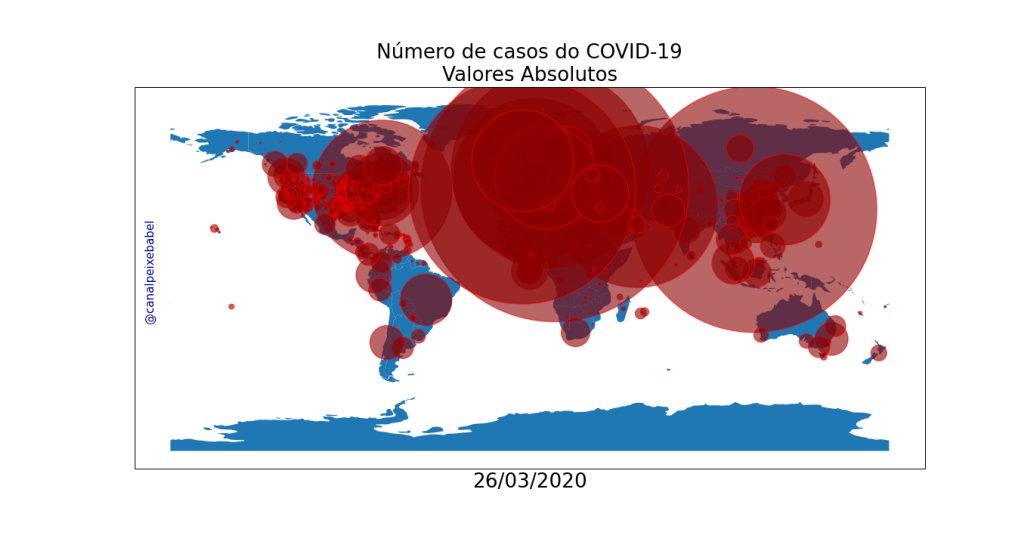

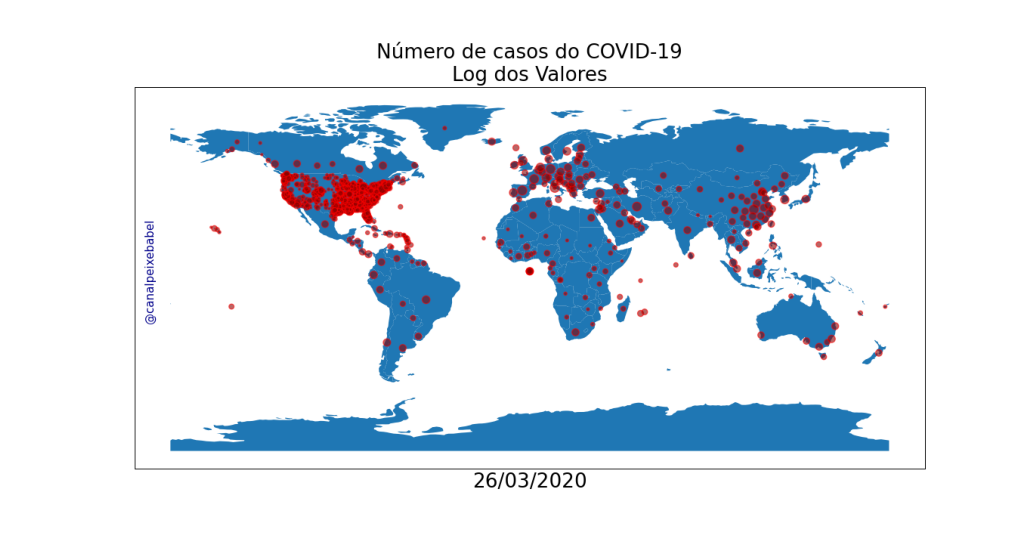

In [7]:
for tipo in ['abs', 'log']:
  plt.figure(figsize=(20, 10))
  img = io.imread('{:s}/{:02d}.png'.format(tipo, len(os.listdir(root_path))))
  plt.imshow(img)
  plt.axis('off')
  plt.savefig("imagens/"+tipo+'.png', dpi=100,format='png')
  plt.show()


In [9]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Capa Log
ax = world.plot(figsize=(15, 8), alpha=0.5)
plt.text(0, 0, 'Número de casos do COVID-19\nLog dos Valores', linespacing=2 ,ha='center', 
        bbox=dict(boxstyle="round",
                  ec=(1., 0.5, 0.5),
                  facecolor=(0.7, 0.1, 0.1, 0.8),
                  ),color='white', fontsize=30)
plt.text(-193,0,'@canalpeixebabel', fontsize=12, va='center', color='darkblue', rotation=90)
plt.savefig('logtitle.png', dpi=100,format='png')
plt.close('all')

# Capa Abs
ax = world.plot(figsize=(15, 8), alpha=0.5)
plt.text(0, 0, 'Número de casos do COVID-19\nValores Absolutos', linespacing=2 ,ha='center', 
        bbox=dict(boxstyle="round",
                  ec=(1., 0.5, 0.5),
                  facecolor=(0.7, 0.1, 0.1, 0.8),
                  ),color='white', fontsize=30)
plt.text(-193,0,'@canalpeixebabel', fontsize=12, va='center', color='darkblue', rotation=90)
plt.savefig('abstitle.png', dpi=100,format='png')
plt.close('all')

In [10]:
os.environ['num_csv'] = str(len(os.listdir(root_path))-2)
!cp abs/$num_csv.png abs/`expr $num_csv + 1`.png
!cp abs/$num_csv.png abs/`expr $num_csv + 2`.png
!cp abs/$num_csv.png abs/`expr $num_csv + 3`.png

!cp log/$num_csv.png log/`expr $num_csv + 1`.png 
!cp log/$num_csv.png log/`expr $num_csv + 2`.png
!cp log/$num_csv.png log/`expr $num_csv + 3`.png

In [12]:
import imageio
images = []
filenames = ['abstitle.png', 'abstitle.png', 'abstitle.png', 'abstitle.png', 'abstitle.png', 'abstitle.png', 'abstitle.png', 'abstitle.png']
filenames.extend(['abs/'+ f for f in sorted(os.listdir('abs/'))] )
filenames.extend( ['logtitle.png', 'logtitle.png', 'logtitle.png', 'logtitle.png', 'logtitle.png', 'logtitle.png', 'logtitle.png'] )
filenames.extend(['log/'+ f for f in sorted(os.listdir('log/'))] )
print(filenames)
for filename in filenames:
    if '.png' in filename:
      images.append(imageio.imread(filename))
imageio.mimsave('imagens/mundial-covid19.gif', images, duration=1/3)
print("mundial-covid19 salvo nos seus arquivos")

['abstitle.png', 'abstitle.png', 'abstitle.png', 'abstitle.png', 'abstitle.png', 'abstitle.png', 'abstitle.png', 'abstitle.png', 'abs/01.png', 'abs/02.png', 'abs/03.png', 'abs/04.png', 'abs/05.png', 'abs/06.png', 'abs/07.png', 'abs/08.png', 'abs/09.png', 'abs/10.png', 'abs/11.png', 'abs/12.png', 'abs/13.png', 'abs/14.png', 'abs/15.png', 'abs/16.png', 'abs/17.png', 'abs/18.png', 'abs/19.png', 'abs/20.png', 'abs/21.png', 'abs/22.png', 'abs/23.png', 'abs/24.png', 'abs/25.png', 'abs/26.png', 'abs/27.png', 'abs/28.png', 'abs/29.png', 'abs/30.png', 'abs/31.png', 'abs/32.png', 'abs/33.png', 'abs/34.png', 'abs/35.png', 'abs/36.png', 'abs/37.png', 'abs/38.png', 'abs/39.png', 'abs/40.png', 'abs/41.png', 'abs/42.png', 'abs/43.png', 'abs/44.png', 'abs/45.png', 'abs/46.png', 'abs/47.png', 'abs/48.png', 'abs/49.png', 'abs/50.png', 'abs/51.png', 'abs/52.png', 'abs/53.png', 'abs/54.png', 'abs/55.png', 'abs/56.png', 'abs/57.png', 'abs/58.png', 'abs/59.png', 'abs/60.png', 'abs/61.png', 'abs/62.png', 'ab